In [14]:
import pandas as pd
import numpy as np
import warnings
import scipy
from keras import optimizers

# Forceasting with decompasable model
from pylab import rcParams

# For marchine Learning Approach
from sklearn.model_selection import train_test_split

import math
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Permute, Reshape, Lambda, RepeatVector, merge, Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [15]:
train = pd.read_csv("../data/raw/nasdaq100/small/nasdaq100_padding.csv")

In [16]:
train.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


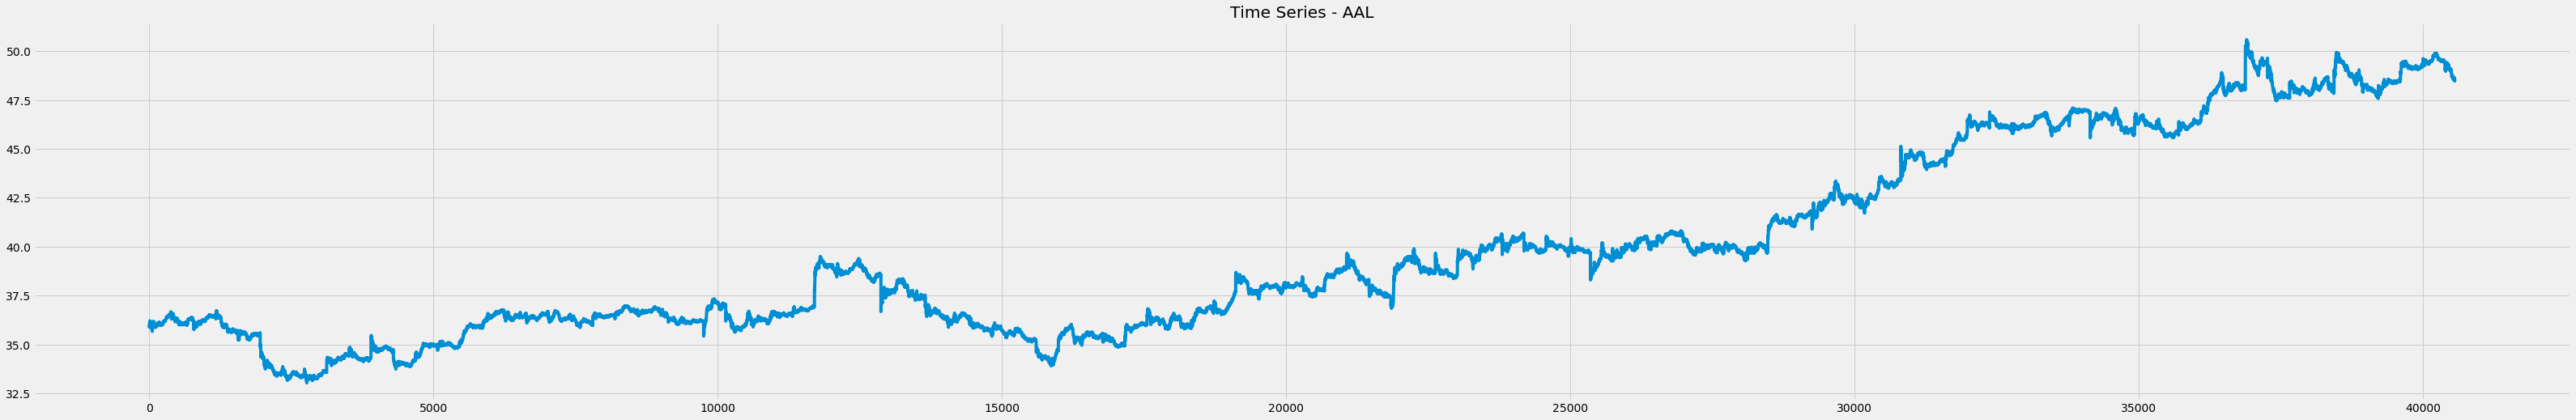

In [17]:
plt.figure(figsize=(50, 8))
train_aal = train["AAL"]
plt.plot(train_aal)
plt.title('Time Series - AAL')
plt.show()

In [18]:
def get_data():
    train = pd.read_csv("../data/raw/nasdaq100/small/nasdaq100_padding.csv")
    dataset = train["AAL"].reset_index(drop=True,).values
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    # dataset = np.expand_dims(dataset, axis=0)
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(dataset.shape[0] * 0.9)
    test_size = dataset.shape[0] - train_size
    train, test = dataset[0:train_size], dataset[train_size:dataset.shape[0]]
    return train, test, scaler, dataset

In [19]:
def create_dataset(dataset, lag):
    dataX, dataY = [], []

    for i in range(len(dataset) - lag - 1):
        a = dataset[i:(i + lag)]
        dataX.append(a)
        dataY.append(dataset[i + lag])
    return np.array(dataX, dtype=float), np.array(dataY, dtype=float)

train, test, scaler, dataset = get_data()
lag = 5
train_aal, train_aal_answer = create_dataset(train, lag=5)
test_aal, test_aal_answer = create_dataset(test, lag=5)


In [20]:
train_aal.shape

(36498, 5, 1)

# SGD noise 

- g = eN/B

In [21]:
# create and fit the LSTM network
print(train_aal.shape)

model = Sequential()
model.add(LSTM(8, input_shape=(lag, 1)))
model.add(Dense(1))
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mae', 'mse'])
model.summary()
model.fit(train_aal, train_aal_answer, epochs=2, batch_size=100)


(36498, 5, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
36498/36498 [==============================] - 4s 107us/step - loss: 0.0028 - mean_absolute_error: 0.0185 - mean_squared_error: 0.0028
Epoch 2/2
36498/36498 [==============================] - 3s 74us/step - loss: 3.1904e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1904e-05


In [22]:
trainPredict = model.predict(train_aal)
testPredict = model.predict(test_aal)
testPredict

array([[0.82953084],
       [0.82891345],
       [0.82868165],
       ...,
       [0.856642  ],
       [0.8568637 ],
       [0.85746276]], dtype=float32)

In [23]:
trainPredict = scaler.inverse_transform(trainPredict)
train_aal_answer = scaler.inverse_transform(train_aal_answer)
trainScore = math.sqrt(mean_squared_error(train_aal_answer, trainPredict))
train_aal_answer.shape

(36498, 1)

In [24]:
testPredict = scaler.inverse_transform(testPredict)
test_aal_answer = scaler.inverse_transform(test_aal_answer)
testScore = math.sqrt(mean_squared_error(test_aal_answer, testPredict))
test_aal_answer.shape

(4050, 1)

In [25]:
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
trainPredict.shape

Train Score: 0.09 RMSE
Test Score: 0.48 RMSE


(36498, 1)

(40560, 1)
(4050, 1)


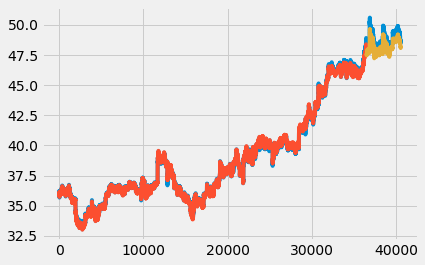

In [26]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (lag * 2) + 1: len(dataset) - 1, :] = testPredict
print(testPredictPlot.shape)
print(testPredict.shape)

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredict)
plt.plot(testPredictPlot)
plt.show()


# Keras Attention

In [27]:
TIME_STEPS = 10
INPUT_DIM = 1

def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = Permute((2,1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation="softmax")(a)
    # a = Lambda(lambda x: K.mean(x, axis=1), name="dim_reduction")(a)
    # a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name="attention_vec")(a)
    output_attention_mul = merge([inputs, a_probs], name="attention_mul", mode="mul")
    return output_attention_mul

def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_unit = 8
    lstm_out = LSTM(lstm_unit, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation="sigmoid")(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 8
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation="sigmoid")(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

# m = model_attention_applied_after_lstm()
m = model_attention_applied_before_lstm()

m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 1, 10)        0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 10)        0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 10)        110         reshape_1[0][0]                  
__________________________________________________________________________________________________
attention_

In [28]:
train, test, scaler, dataset = get_data()
lag = 10
train_aal, train_aal_answer = create_dataset(train, lag=lag)
test_aal, test_aal_answer = create_dataset(test, lag=lag)

m.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mae', 'mse'])
m.fit(train_aal, train_aal_answer, epochs=3, batch_size=100)

Epoch 1/3
36493/36493 [==============================] - 6s 178us/step - loss: 0.0461 - mean_absolute_error: 0.1744 - mean_squared_error: 0.0461
Epoch 2/3
36493/36493 [==============================] - 5s 127us/step - loss: 0.0270 - mean_absolute_error: 0.1223 - mean_squared_error: 0.0270
Epoch 3/3
36493/36493 [==============================] - 5s 128us/step - loss: 0.0017 - mean_absolute_error: 0.0317 - mean_squared_error: 0.0017


In [29]:
def get_activation(model, inputs, print_shape_only=False, layer_name=None):
    print("---- activations ----")
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

attention_vectors = []
for i in range(10):
    attention_vector = np.mean(get_activation(m, 
                                              test_aal, 
                                              print_shape_only=True, 
                                              layer_name="attention_vec")[0], axis=2).squeeze()
    print("attention =", attention_vector)
    print("sum attention =", sum(attention_vector))
    
    # assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)



---- activations ----
(4045, 10, 1)
attention = [[0.19819704 0.02865401 0.06396986 ... 0.04998811 0.1446893  0.15377243]
 [0.19766778 0.02869176 0.06408399 ... 0.04995826 0.14468575 0.1536151 ]
 [0.19740263 0.0286642  0.06428826 ... 0.05011056 0.14497377 0.15345941]
 ...
 [0.2007857  0.026706   0.06202683 ... 0.04787107 0.14544167 0.15441568]
 [0.20113283 0.02669766 0.06196178 ... 0.04799897 0.14558148 0.15403515]
 [0.20102614 0.02668254 0.06184875 ... 0.04802703 0.14541769 0.15394233]]
sum attention = [813.7145  106.36428 248.85875 369.9888  960.7375   73.08846  66.77009
 192.9553  589.7846  622.7382 ]
---- activations ----
(4045, 10, 1)
attention = [[0.19819704 0.02865401 0.06396986 ... 0.04998811 0.1446893  0.15377243]
 [0.19766778 0.02869176 0.06408399 ... 0.04995826 0.14468575 0.1536151 ]
 [0.19740263 0.0286642  0.06428826 ... 0.05011056 0.14497377 0.15345941]
 ...
 [0.2007857  0.026706   0.06202683 ... 0.04787107 0.14544167 0.15441568]
 [0.20113283 0.02669766 0.06196178 ... 0.047

(40450, 1)
[[0.19819702]
 [0.02865401]
 [0.06396986]
 ...
 [0.04802703]
 [0.14541769]
 [0.15394233]]


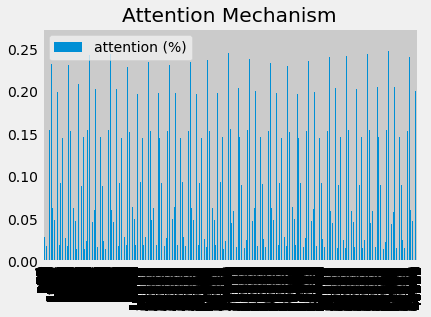

In [33]:
attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
attention_vector_final = attention_vector_final.reshape(-1, 1)
print(attention_vector_final.shape)
print(attention_vector_final)
pd.DataFrame(attention_vector_final, columns=["attention (%)"]).plot(kind="bar", title="Attention Mechanism")
plt.figure(figsize=(20,20))
plt.show()

In [31]:
trainPredict = m.predict(train_aal)
testPredict = m.predict(test_aal)

trainPredict = scaler.inverse_transform(trainPredict)
train_aal_answer = scaler.inverse_transform(train_aal_answer)
trainScore = math.sqrt(mean_squared_error(train_aal_answer, trainPredict))

testPredict = scaler.inverse_transform(testPredict)
test_aal_answer = scaler.inverse_transform(test_aal_answer)
testScore = math.sqrt(mean_squared_error(test_aal_answer, testPredict))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.80 RMSE
Test Score: 2.44 RMSE


(40560, 1)
(4045, 1)


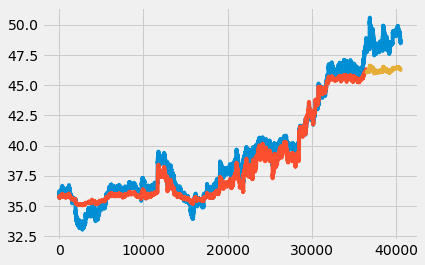

In [32]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (lag * 2) + 1: len(dataset) - 1, :] = testPredict
print(testPredictPlot.shape)
print(testPredict.shape)

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredict)
plt.plot(testPredictPlot)
plt.show()

# Keras Attention Encoder Decoder

In [36]:
import os
try:
    user_paths = os.environ['PYTHONPATH'].split(os.pathsep)
except KeyError:
    user_paths = []
    
print(user_paths)

from models.attention_decoder import AttentionDecoder

def attention_model(time_step, n_features):
    model = Sequential()
    model.add(LSTM(150, input_shape=(time_step, n_feature), return_sequences=True))
    model.add(AttentionDecoder(150, n_features))
    model.compile(loss="mean_squared_error", optimizer=sgd, metrics=["mse", "mae"])

[]


ModuleNotFoundError: No module named 'models'